In [14]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import vgg

In [16]:


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

batch_size = 4
workers = 4

In [17]:
train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True)


test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True)

Files already downloaded and verified


In [21]:
# load the model

model_names = sorted(name for name in vgg.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("vgg")
                     and callable(vgg.__dict__[name]))


parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('--arch', '-a', metavar='ARCH', default='vgg19',
                    choices=model_names,
                    help='model architecture: ' + ' | '.join(model_names) +
                    ' (default: vgg19)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--lr', '--learning-rate', default=0.05, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float,
                    metavar='W', help='weight decay (default: 5e-4)')
parser.add_argument('--print-freq', '-p', default=20, type=int,
                    metavar='N', help='print frequency (default: 20)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--half', dest='half', action='store_true',
                    help='use half-precision(16-bit) ')
parser.add_argument('--cpu', dest='cpu', action='store_true',
                    help='use cpu')
parser.add_argument('--save-dir', dest='save_dir',
                    help='The directory used to save the trained models',
                    default='save_temp', type=str)


def model(resume, cpu=True, arch='vgg19', evaluate=True):

    model = vgg.__dict__[arch]()

    model.features = torch.nn.DataParallel(model.features)
    if cpu:
        model.cpu()
    else:
        model.cuda()

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(evaluate, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))
    return model

model = model(resume='./model_best_cpu.pth.tar')


cudnn.benchmark = True



=> no checkpoint found at './model_best_cpu.pth.tar'


In [22]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


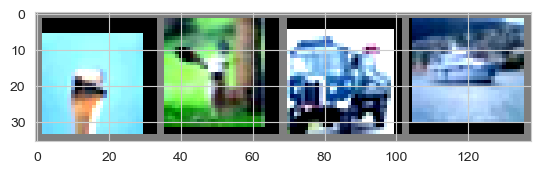

bird  deer  truck ship 


In [23]:
# have a look at the training data

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


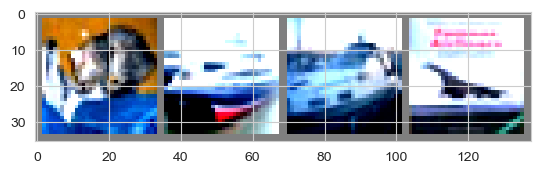

GroundTruth:  cat   ship  ship  plane


In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [25]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [26]:
# what are the classes that performed well, and the classes that did not perform well:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 2.3 %
Accuracy for class: car   is 6.2 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 30.0 %
Accuracy for class: frog  is 0.6 %
Accuracy for class: horse is 9.3 %
Accuracy for class: ship  is 54.5 %
Accuracy for class: truck is 0.0 %
